# Resources
https://pytorch.org/vision/master/models.html
https://pytorch.org/vision/master/models/faster_rcnn.html

In [ ]:
import os
if not os.path.exists('./models'):
    os.makedirs('./models')
if not os.path.exists('./models/model_history'):
    os.makedirs('./models/model_history')

In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
import torch

print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn, FasterRCNN_MobileNet_V3_Large_320_FPN_Weights
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import json

In [3]:
def collate_fn(batch):
  images = [b[0] for b in batch]
  labels = [b[1] for b in batch]
  name = [b[2] for b in batch]

  return (images, labels, name)

class BBoxImageDataset(Dataset):
  def __init__(self, data_file, image_dir, transform=None, target_transform=None):
    with open(data_file, 'r') as file:
      self.data = json.load(file)

    self.image_dir = image_dir
    self.transform = transform
    self.target_transform = target_transform

    # create bounding boxes as list of (1 by 4) tensors
    bboxes = [torch.tensor([self.data[file]["bbox"]], dtype=torch.float32).view(1, 4) for file in self.data.keys()]
    classes = [torch.tensor(1, dtype=torch.int64) for i in range(len(bboxes))]

    img_labels = []
    for file in list(self.data.keys()):
      t_dict = {}
      t_dict['boxes'] = torch.tensor([self.data[file]["bbox"]], dtype=torch.float32)
      t_dict['labels'] = torch.tensor([1], dtype=torch.int64)
      img_labels.append(t_dict)

    self.img_labels = img_labels


    # self.img_labels = [[box, cls] for box, cls in zip(bboxes, classes)]


  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    name = str(list(self.data.keys())[idx])
    img_path = f"{self.image_dir}/{name}.png"
    image = read_image(img_path)
    label = self.img_labels[idx]

    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)

    return (image, label, name)

In [4]:
transform = FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1.transforms()

batch_size = 8

train_data_file = './data/train_data.json'
test_data_file = './data/test_data.json'
image_dir = './data/color'

trainset = BBoxImageDataset(train_data_file, image_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          collate_fn=collate_fn)

testset = BBoxImageDataset(test_data_file, image_dir, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=True, collate_fn=collate_fn, num_workers=2)

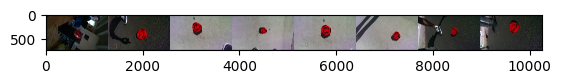

[{'boxes': tensor([[569.3200, 324.7700, 746.8500, 486.9900]]), 'labels': tensor([1])}, {'boxes': tensor([[597.9600, 294.6400, 812.6800, 521.4400]]), 'labels': tensor([1])}, {'boxes': tensor([[457.6200, 164.1000, 657.8800, 373.9000]]), 'labels': tensor([1])}, {'boxes': tensor([[587.6400, 266.1400, 721.4700, 401.5300]]), 'labels': tensor([1])}, {'boxes': tensor([[558.6900, 216.4800, 769.4200, 437.8400]]), 'labels': tensor([1])}, {'boxes': tensor([[752.2900, 351.6900, 922.0400, 509.2600]]), 'labels': tensor([1])}, {'boxes': tensor([[684.7700, 270.0100, 826.9200, 425.6500]]), 'labels': tensor([1])}, {'boxes': tensor([[611.5500, 159.7200, 804.8000, 380.4600]]), 'labels': tensor([1])}]


In [5]:
# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, targets, _ = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print
#print(images)
print(targets)
#print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = fasterrcnn_mobilenet_v3_large_320_fpn(weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (fuelcap) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=1,
    gamma=0.5
)

Using device: cuda


In [8]:
batches_between_prints = 11

def train_one_epoch(model, trainloader, optimizer, losses_train, epoch):
    losses_train.append([])
    model.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets, _ = data

        inputs = [tensor.to(device) for tensor in inputs]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        outputs = model(inputs, targets)

        # calculate lossess
        losses = sum(loss for loss in outputs.values())
        losses_train[-1].append(losses.detach())

        # backward + optimize
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % batches_between_prints == batches_between_prints-1:    # print every 5 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {sum(losses_train[-1]) / (i+1):.3f}')

def test_model(model, testloader):
    running_loss = 0.0
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets, _ = data

        inputs = [tensor.to(device) for tensor in inputs]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        outputs = model(inputs, targets)
        losses = sum(loss for loss in outputs.values())
        running_loss += losses.detach()
    return float(running_loss/(i+1))

In [9]:
model_name = "bbox_net"
hist_count = 0

num_epochs = 10

losses_train = []
losses_test = []

model = model.to(device)

# test the model before any training
losses_test.append(test_model(model, testloader))

for epoch in range(num_epochs):  # loop over the dataset multiple times

    # train the model
    train_one_epoch(model, trainloader, optimizer, losses_train, epoch)
    
    # test the model
    losses_test.append(test_model(model, testloader))

    # update the learning rate
    lr_scheduler.step()

    print(f'Epoch {epoch+1} complete. train loss: {sum(losses_train[-1]) / len(losses_train[-1]):0.5f}, test loss: {losses_test[-1]:0.5f}')

    if epoch % 1 == 0:
        torch.save(model, f"./models/{model_name}_quick.pth")

    if epoch % 10 == 0:
        torch.save(model, f"./models/model_history/{model_name}{hist_count}.pth")
        hist_count += 1

[1,    11] loss: 0.520
[1,    22] loss: 0.503
[1,    33] loss: 0.565
[1,    44] loss: 0.558
[1,    55] loss: 0.546
[1,    66] loss: 0.521
[1,    77] loss: 0.500
[1,    88] loss: 0.504
Epoch 1 complete. train loss: 0.50353, test loss: 0.65866
[2,    11] loss: 0.485
[2,    22] loss: 0.401
[2,    33] loss: 0.368
[2,    44] loss: 0.353
[2,    55] loss: 0.343
[2,    66] loss: 0.337
[2,    77] loss: 0.330
[2,    88] loss: 0.330
Epoch 2 complete. train loss: 0.32989, test loss: 0.28795
[3,    11] loss: 0.249
[3,    22] loss: 0.225
[3,    33] loss: 0.218
[3,    44] loss: 0.210
[3,    55] loss: 0.203
[3,    66] loss: 0.200
[3,    77] loss: 0.197
[3,    88] loss: 0.195
Epoch 3 complete. train loss: 0.19534, test loss: 0.17619
[4,    11] loss: 0.150
[4,    22] loss: 0.153
[4,    33] loss: 0.148
[4,    44] loss: 0.149
[4,    55] loss: 0.152
[4,    66] loss: 0.154
[4,    77] loss: 0.153
[4,    88] loss: 0.152
Epoch 4 complete. train loss: 0.15158, test loss: 0.17883
[5,    11] loss: 0.147
[5,    22

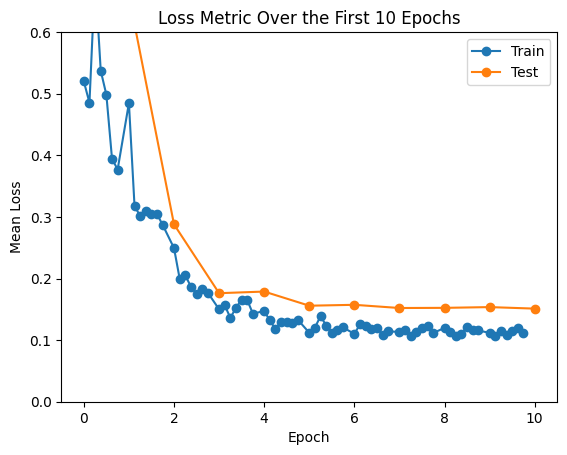

In [10]:
x_test = range(0, num_epochs+1)
test_scores = losses_test

batches_between_prints = 11

x_train = []
train_scores = []
for i in range(0, num_epochs):
    for j in range(0, len(losses_train[i])-batches_between_prints, batches_between_prints):
        x_train.append(i + j/len(losses_train[i]))
        train_scores.append(float(sum(losses_train[i][j:(j+batches_between_prints)])/batches_between_prints))

plt.plot(x_train, train_scores, '-o', label='Train')
plt.plot(x_test, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Loss')
plt.title('Loss Metric Over the First 10 Epochs')
plt.ylim((0, 0.6))
plt.show()

inference time: 0.0539 seconds
inference time: 18.5665 Hz
(651, 332)
529


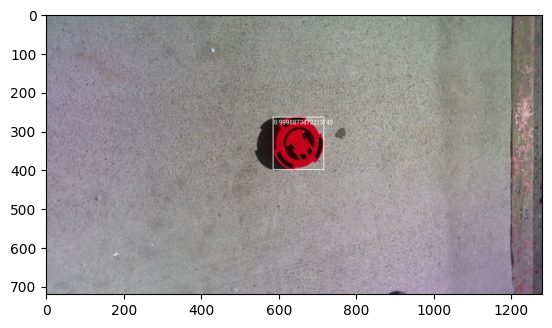

In [12]:
import time
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

model.eval()
model.cpu()

# get some random training images
dataiter = iter(testloader)
images, labels, filenames = next(dataiter)
img = images[0]
#img = read_image('./data/test_img.png')
#img = transform(img)

tic = time.perf_counter()
#img = img.to(device)
prediction = model([img])[0]
toc = time.perf_counter()
print(f'inference time: {(toc-tic):0.4f} seconds')
print(f'inference time: {1/(toc-tic):0.4f} Hz')

img = (img*255).type(torch.uint8)

boxes = prediction["boxes"]
labels = [str(int(x)) for x in prediction["labels"]]
scores = [float(x) for x in prediction["scores"]]

output_boxes = []
output_labels = []
for i in range(len(labels)):
  if scores[i] >= 0:
    output_boxes.append(boxes[i:i+1])
    output_labels.append(str(scores[i]))
output_boxes = torch.concat(output_boxes)

bbox_center = (int((output_boxes[0][2] + output_boxes[0][0])/2), int((output_boxes[0][3] + output_boxes[0][1])/2))
depth_img = np.load(f'./data/depth/{filenames[0]}.npy')
print(bbox_center)
print(depth_img[bbox_center[1], bbox_center[0]])

box = draw_bounding_boxes(img, boxes=output_boxes,
                          labels=output_labels,
                          colors="white",
                          font='/usr/share/fonts/truetype/roboto-slab/RobotoSlab-Regular.ttf',
                          width=2, font_size=16)
imshow(box)
im = to_pil_image(box.detach())
im.save('./image.png', 'PNG')

In [13]:
PATH = './bbox_net.pth'

torch.save(model, PATH)
# model.eval()

In [9]:
PATH = './bbox_net.pth'
model = fasterrcnn_mobilenet_v3_large_320_fpn(weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (fuelcap) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = torch.load(PATH)
# model.eval()

In [124]:
torch.cuda.empty_cache()

# Test the network

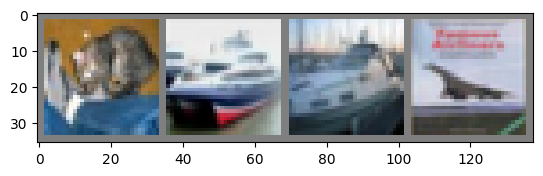

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [35]:


model = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load(PATH))

RuntimeError: Error(s) in loading state_dict for FastRCNNPredictor:
	Missing key(s) in state_dict: "cls_score.weight", "cls_score.bias", "bbox_pred.weight", "bbox_pred.bias". 
	Unexpected key(s) in state_dict: "backbone.body.0.0.weight", "backbone.body.0.1.weight", "backbone.body.0.1.bias", "backbone.body.0.1.running_mean", "backbone.body.0.1.running_var", "backbone.body.1.block.0.0.weight", "backbone.body.1.block.0.1.weight", "backbone.body.1.block.0.1.bias", "backbone.body.1.block.0.1.running_mean", "backbone.body.1.block.0.1.running_var", "backbone.body.1.block.1.0.weight", "backbone.body.1.block.1.1.weight", "backbone.body.1.block.1.1.bias", "backbone.body.1.block.1.1.running_mean", "backbone.body.1.block.1.1.running_var", "backbone.body.2.block.0.0.weight", "backbone.body.2.block.0.1.weight", "backbone.body.2.block.0.1.bias", "backbone.body.2.block.0.1.running_mean", "backbone.body.2.block.0.1.running_var", "backbone.body.2.block.1.0.weight", "backbone.body.2.block.1.1.weight", "backbone.body.2.block.1.1.bias", "backbone.body.2.block.1.1.running_mean", "backbone.body.2.block.1.1.running_var", "backbone.body.2.block.2.0.weight", "backbone.body.2.block.2.1.weight", "backbone.body.2.block.2.1.bias", "backbone.body.2.block.2.1.running_mean", "backbone.body.2.block.2.1.running_var", "backbone.body.3.block.0.0.weight", "backbone.body.3.block.0.1.weight", "backbone.body.3.block.0.1.bias", "backbone.body.3.block.0.1.running_mean", "backbone.body.3.block.0.1.running_var", "backbone.body.3.block.1.0.weight", "backbone.body.3.block.1.1.weight", "backbone.body.3.block.1.1.bias", "backbone.body.3.block.1.1.running_mean", "backbone.body.3.block.1.1.running_var", "backbone.body.3.block.2.0.weight", "backbone.body.3.block.2.1.weight", "backbone.body.3.block.2.1.bias", "backbone.body.3.block.2.1.running_mean", "backbone.body.3.block.2.1.running_var", "backbone.body.4.block.0.0.weight", "backbone.body.4.block.0.1.weight", "backbone.body.4.block.0.1.bias", "backbone.body.4.block.0.1.running_mean", "backbone.body.4.block.0.1.running_var", "backbone.body.4.block.1.0.weight", "backbone.body.4.block.1.1.weight", "backbone.body.4.block.1.1.bias", "backbone.body.4.block.1.1.running_mean", "backbone.body.4.block.1.1.running_var", "backbone.body.4.block.2.fc1.weight", "backbone.body.4.block.2.fc1.bias", "backbone.body.4.block.2.fc2.weight", "backbone.body.4.block.2.fc2.bias", "backbone.body.4.block.3.0.weight", "backbone.body.4.block.3.1.weight", "backbone.body.4.block.3.1.bias", "backbone.body.4.block.3.1.running_mean", "backbone.body.4.block.3.1.running_var", "backbone.body.5.block.0.0.weight", "backbone.body.5.block.0.1.weight", "backbone.body.5.block.0.1.bias", "backbone.body.5.block.0.1.running_mean", "backbone.body.5.block.0.1.running_var", "backbone.body.5.block.1.0.weight", "backbone.body.5.block.1.1.weight", "backbone.body.5.block.1.1.bias", "backbone.body.5.block.1.1.running_mean", "backbone.body.5.block.1.1.running_var", "backbone.body.5.block.2.fc1.weight", "backbone.body.5.block.2.fc1.bias", "backbone.body.5.block.2.fc2.weight", "backbone.body.5.block.2.fc2.bias", "backbone.body.5.block.3.0.weight", "backbone.body.5.block.3.1.weight", "backbone.body.5.block.3.1.bias", "backbone.body.5.block.3.1.running_mean", "backbone.body.5.block.3.1.running_var", "backbone.body.6.block.0.0.weight", "backbone.body.6.block.0.1.weight", "backbone.body.6.block.0.1.bias", "backbone.body.6.block.0.1.running_mean", "backbone.body.6.block.0.1.running_var", "backbone.body.6.block.1.0.weight", "backbone.body.6.block.1.1.weight", "backbone.body.6.block.1.1.bias", "backbone.body.6.block.1.1.running_mean", "backbone.body.6.block.1.1.running_var", "backbone.body.6.block.2.fc1.weight", "backbone.body.6.block.2.fc1.bias", "backbone.body.6.block.2.fc2.weight", "backbone.body.6.block.2.fc2.bias", "backbone.body.6.block.3.0.weight", "backbone.body.6.block.3.1.weight", "backbone.body.6.block.3.1.bias", "backbone.body.6.block.3.1.running_mean", "backbone.body.6.block.3.1.running_var", "backbone.body.7.block.0.0.weight", "backbone.body.7.block.0.1.weight", "backbone.body.7.block.0.1.bias", "backbone.body.7.block.0.1.running_mean", "backbone.body.7.block.0.1.running_var", "backbone.body.7.block.1.0.weight", "backbone.body.7.block.1.1.weight", "backbone.body.7.block.1.1.bias", "backbone.body.7.block.1.1.running_mean", "backbone.body.7.block.1.1.running_var", "backbone.body.7.block.2.0.weight", "backbone.body.7.block.2.1.weight", "backbone.body.7.block.2.1.bias", "backbone.body.7.block.2.1.running_mean", "backbone.body.7.block.2.1.running_var", "backbone.body.8.block.0.0.weight", "backbone.body.8.block.0.1.weight", "backbone.body.8.block.0.1.bias", "backbone.body.8.block.0.1.running_mean", "backbone.body.8.block.0.1.running_var", "backbone.body.8.block.1.0.weight", "backbone.body.8.block.1.1.weight", "backbone.body.8.block.1.1.bias", "backbone.body.8.block.1.1.running_mean", "backbone.body.8.block.1.1.running_var", "backbone.body.8.block.2.0.weight", "backbone.body.8.block.2.1.weight", "backbone.body.8.block.2.1.bias", "backbone.body.8.block.2.1.running_mean", "backbone.body.8.block.2.1.running_var", "backbone.body.9.block.0.0.weight", "backbone.body.9.block.0.1.weight", "backbone.body.9.block.0.1.bias", "backbone.body.9.block.0.1.running_mean", "backbone.body.9.block.0.1.running_var", "backbone.body.9.block.1.0.weight", "backbone.body.9.block.1.1.weight", "backbone.body.9.block.1.1.bias", "backbone.body.9.block.1.1.running_mean", "backbone.body.9.block.1.1.running_var", "backbone.body.9.block.2.0.weight", "backbone.body.9.block.2.1.weight", "backbone.body.9.block.2.1.bias", "backbone.body.9.block.2.1.running_mean", "backbone.body.9.block.2.1.running_var", "backbone.body.10.block.0.0.weight", "backbone.body.10.block.0.1.weight", "backbone.body.10.block.0.1.bias", "backbone.body.10.block.0.1.running_mean", "backbone.body.10.block.0.1.running_var", "backbone.body.10.block.1.0.weight", "backbone.body.10.block.1.1.weight", "backbone.body.10.block.1.1.bias", "backbone.body.10.block.1.1.running_mean", "backbone.body.10.block.1.1.running_var", "backbone.body.10.block.2.0.weight", "backbone.body.10.block.2.1.weight", "backbone.body.10.block.2.1.bias", "backbone.body.10.block.2.1.running_mean", "backbone.body.10.block.2.1.running_var", "backbone.body.11.block.0.0.weight", "backbone.body.11.block.0.1.weight", "backbone.body.11.block.0.1.bias", "backbone.body.11.block.0.1.running_mean", "backbone.body.11.block.0.1.running_var", "backbone.body.11.block.1.0.weight", "backbone.body.11.block.1.1.weight", "backbone.body.11.block.1.1.bias", "backbone.body.11.block.1.1.running_mean", "backbone.body.11.block.1.1.running_var", "backbone.body.11.block.2.fc1.weight", "backbone.body.11.block.2.fc1.bias", "backbone.body.11.block.2.fc2.weight", "backbone.body.11.block.2.fc2.bias", "backbone.body.11.block.3.0.weight", "backbone.body.11.block.3.1.weight", "backbone.body.11.block.3.1.bias", "backbone.body.11.block.3.1.running_mean", "backbone.body.11.block.3.1.running_var", "backbone.body.12.block.0.0.weight", "backbone.body.12.block.0.1.weight", "backbone.body.12.block.0.1.bias", "backbone.body.12.block.0.1.running_mean", "backbone.body.12.block.0.1.running_var", "backbone.body.12.block.1.0.weight", "backbone.body.12.block.1.1.weight", "backbone.body.12.block.1.1.bias", "backbone.body.12.block.1.1.running_mean", "backbone.body.12.block.1.1.running_var", "backbone.body.12.block.2.fc1.weight", "backbone.body.12.block.2.fc1.bias", "backbone.body.12.block.2.fc2.weight", "backbone.body.12.block.2.fc2.bias", "backbone.body.12.block.3.0.weight", "backbone.body.12.block.3.1.weight", "backbone.body.12.block.3.1.bias", "backbone.body.12.block.3.1.running_mean", "backbone.body.12.block.3.1.running_var", "backbone.body.13.block.0.0.weight", "backbone.body.13.block.0.1.weight", "backbone.body.13.block.0.1.bias", "backbone.body.13.block.0.1.running_mean", "backbone.body.13.block.0.1.running_var", "backbone.body.13.block.1.0.weight", "backbone.body.13.block.1.1.weight", "backbone.body.13.block.1.1.bias", "backbone.body.13.block.1.1.running_mean", "backbone.body.13.block.1.1.running_var", "backbone.body.13.block.2.fc1.weight", "backbone.body.13.block.2.fc1.bias", "backbone.body.13.block.2.fc2.weight", "backbone.body.13.block.2.fc2.bias", "backbone.body.13.block.3.0.weight", "backbone.body.13.block.3.1.weight", "backbone.body.13.block.3.1.bias", "backbone.body.13.block.3.1.running_mean", "backbone.body.13.block.3.1.running_var", "backbone.body.14.block.0.0.weight", "backbone.body.14.block.0.1.weight", "backbone.body.14.block.0.1.bias", "backbone.body.14.block.0.1.running_mean", "backbone.body.14.block.0.1.running_var", "backbone.body.14.block.1.0.weight", "backbone.body.14.block.1.1.weight", "backbone.body.14.block.1.1.bias", "backbone.body.14.block.1.1.running_mean", "backbone.body.14.block.1.1.running_var", "backbone.body.14.block.2.fc1.weight", "backbone.body.14.block.2.fc1.bias", "backbone.body.14.block.2.fc2.weight", "backbone.body.14.block.2.fc2.bias", "backbone.body.14.block.3.0.weight", "backbone.body.14.block.3.1.weight", "backbone.body.14.block.3.1.bias", "backbone.body.14.block.3.1.running_mean", "backbone.body.14.block.3.1.running_var", "backbone.body.15.block.0.0.weight", "backbone.body.15.block.0.1.weight", "backbone.body.15.block.0.1.bias", "backbone.body.15.block.0.1.running_mean", "backbone.body.15.block.0.1.running_var", "backbone.body.15.block.1.0.weight", "backbone.body.15.block.1.1.weight", "backbone.body.15.block.1.1.bias", "backbone.body.15.block.1.1.running_mean", "backbone.body.15.block.1.1.running_var", "backbone.body.15.block.2.fc1.weight", "backbone.body.15.block.2.fc1.bias", "backbone.body.15.block.2.fc2.weight", "backbone.body.15.block.2.fc2.bias", "backbone.body.15.block.3.0.weight", "backbone.body.15.block.3.1.weight", "backbone.body.15.block.3.1.bias", "backbone.body.15.block.3.1.running_mean", "backbone.body.15.block.3.1.running_var", "backbone.body.16.0.weight", "backbone.body.16.1.weight", "backbone.body.16.1.bias", "backbone.body.16.1.running_mean", "backbone.body.16.1.running_var", "backbone.fpn.inner_blocks.0.0.weight", "backbone.fpn.inner_blocks.0.0.bias", "backbone.fpn.inner_blocks.1.0.weight", "backbone.fpn.inner_blocks.1.0.bias", "backbone.fpn.layer_blocks.0.0.weight", "backbone.fpn.layer_blocks.0.0.bias", "backbone.fpn.layer_blocks.1.0.weight", "backbone.fpn.layer_blocks.1.0.bias", "rpn.head.conv.0.0.weight", "rpn.head.conv.0.0.bias", "rpn.head.cls_logits.weight", "rpn.head.cls_logits.bias", "rpn.head.bbox_pred.weight", "rpn.head.bbox_pred.bias", "roi_heads.box_head.fc6.weight", "roi_heads.box_head.fc6.bias", "roi_heads.box_head.fc7.weight", "roi_heads.box_head.fc7.bias", "roi_heads.box_predictor.cls_score.weight", "roi_heads.box_predictor.cls_score.bias", "roi_heads.box_predictor.bbox_pred.weight", "roi_heads.box_predictor.bbox_pred.bias". 

In [ ]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 54.9 %
Accuracy for class: car   is 75.8 %
Accuracy for class: bird  is 42.0 %
Accuracy for class: cat   is 51.8 %
Accuracy for class: deer  is 32.2 %
Accuracy for class: dog   is 38.1 %
Accuracy for class: frog  is 69.4 %
Accuracy for class: horse is 64.1 %
Accuracy for class: ship  is 70.3 %
Accuracy for class: truck is 61.5 %
